<a href="https://colab.research.google.com/github/yingted/jax-smallpt/blob/master/smallpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Make sure the Colab Runtime is set to Accelerator: TPU.
import requests
import os
if 'TPU_DRIVER_MODE' not in globals():
  url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
  resp = requests.post(url)
  TPU_DRIVER_MODE = 1

# The following is required to use TPU Driver as JAX's backend.
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
print(config.FLAGS.jax_backend_target)

grpc://10.116.9.122:8470


In [0]:
# See original: http://www.kevinbeason.com/smallpt/
import jax.numpy as jnp
import jax
import numpy as np
import typing
import functools
import matplotlib.pyplot as plt
%matplotlib inline

Vec3 = jnp.ndarray
Color = Vec3
class Ray(typing.NamedTuple):
  origin: Vec3
  direction: Vec3  # unit vector
class Material(int):  # IntEnum doesn't work here
  DIFFUSE = 1
  SPECULAR = 2
  REFRACTIVE = 3
class Sphere(typing.NamedTuple):
  radius: float
  position: Vec3
  emission: Color
  color: Color
  material: Material
  def intersect(self, ray: Ray) -> typing.Tuple[bool, float]:
    """Calculates the intersection point with a ray.

    Args:
      ray: the ray to intersect with

    Returns:
      hit: np.bool whether it intersected
      into: np.bool whether it's entering
      t: the distance along the ray (origin + t * direction)
    """
    offset = self.position - ray.origin
    # Calculate the closest point on the ray to the origin.
    # The ray is heading in the positive direction.
    closest_t = jnp.dot(offset, ray.direction)
    # Find the power of the closest point (positive for outside the radius).
    # On TPU, x**2 is sometimes computed to half precision while x*x is not,
    # which leads to being unable to find the light source.
    # power_of_closest = jnp.dot(offset, offset) - closest_t**2 - self.radius**2
    power_of_closest = jnp.dot(offset, offset) - closest_t*closest_t - self.radius*self.radius
    hit = power_of_closest <= 0
    # Find the intersection points. At least one must be positive.
    # Assuming the ray can be cast from inside the sphere, check both surfaces.
    # Ignore any spheres we're touching or almost touching.
    eps = 1e-2
    sine = jnp.sqrt(-power_of_closest)
    t1 = closest_t - sine  # outer surface of the sphere
    t2 = closest_t + sine  # inner surface of the sphere
    # We need to do this bit without branching.
    hit = hit & (t2 > eps)
    t = jnp.where(t1 > eps, t1, t2)

    # For debugging TPU precision:
    # import pprint; pprint.pprint(locals())
    return hit, t

O = np.r_[0., 0, 0]
spheres = (
   Sphere(1e5,  np.r_[ 1e5+1,40.8,81.6],  O, np.r_[.75,.25,.25], Material.DIFFUSE),     # left
   Sphere(1e5,  np.r_[-1e5+99,40.8,81.6], O, np.r_[.25,.25,.75], Material.DIFFUSE),     # right
   Sphere(1e5,  np.r_[50,40.8, 1e5],      O, np.r_[.75,.75,.75], Material.DIFFUSE),     # back
   Sphere(1e5,  np.r_[50,40.8,-1e5+170],  O,                  O, Material.DIFFUSE),     # front
   Sphere(1e5,  np.r_[50, 1e5, 81.6],     O, np.r_[.75,.75,.75], Material.DIFFUSE),     # bottom
   Sphere(1e5,  np.r_[50,-1e5+81.6,81.6], O, np.r_[.75,.75,.75], Material.DIFFUSE),     # top
   Sphere(16.5, np.r_[27,16.5,47],     O, np.r_[1, 1, 1] * .999, Material.SPECULAR),    # metal ball
   Sphere(16.5, np.r_[73,16.5,78],     O, np.r_[1, 1, 1] * .999, Material.REFRACTIVE),  # glass ball
   Sphere(600,  np.r_[50,681.6-.27,81.6], np.r_[12.,12,12],   O, Material.DIFFUSE),     # light
)
spheres_T = jax.tree_multimap(lambda *x: jnp.stack(x), *spheres)

def cached_property(func):
  """Decorator to cache a property of a namedtuple.
  
  On TPU, this speeds up the compiled code by 2x.
  """
  cache = {}
  @functools.wraps(func)
  def wrapped(self):
    id_ = id(self)
    value = cache.get(id_)
    if value is None:
      cache[id_] = value = (self, func(self))
    return value[1]
  return property(wrapped)

class Hit(typing.NamedTuple):
  """A hit between a ray and a sphere."""
  # Whether or not the hit exists:
  exists: bool
  # Signed distance from origin:
  t: float
  # Objects involved:
  sphere_index: int
  ray: Ray

  @cached_property
  def sphere(self) -> Sphere:
    i = self.sphere_index
    # Get the ith sphere, with a TPU-specific optimization:
    if type(jax.devices()[0]).__name__ == 'TpuDevice':
      one_hot = jnp.arange(len(spheres)) == i
      return jax.tree_map(lambda x: (one_hot @ x.astype(jnp.float32)).astype(x.dtype), spheres_T)
    return jax.tree_map(lambda x: x[i], spheres_T)

  @cached_property
  def intersection(self) -> Vec3:
    return self.ray.origin + self.t * self.ray.direction

  @cached_property
  def normal_out(self) -> Vec3:
    """Returns the surface normal facing out of the sphere."""
    normal_out = self.intersection - self.sphere.position
    normal_out /= jnp.linalg.norm(normal_out, ord=2)
    return normal_out

  @cached_property
  def is_entering(self) -> Vec3:
    return jnp.dot(self.normal_out, self.ray.direction) < 0

  @cached_property
  def normal_forward(self) -> Vec3:
    """Returns the surface normal, facing along the ray."""
    return jnp.where(self.is_entering, -self.normal_out, self.normal_out)

  @cached_property
  def normal_backward(self) -> Vec3:
    """Returns the surface normal, facing against the ray."""
    return -self.normal_forward

@jax.jit
def intersect(ray: Ray, avoid: int) -> Hit:
  """Calculates the intersection point with a ray.
  
  Args:
    ray: the ray to intersect with
    avoid: int which sphere to avoid, or -1 for none

  Returns:
    hit: np.bool whether it intersected
    t: the distance along the ray (origin + t * direction)
    i: the index of the sphere we hit
  """
  # Find which sphere got hit:
  oo = 1e20
  hits, ts = jax.vmap(lambda sphere: sphere.intersect(ray))(spheres_T)
  ts = jnp.where(hits, ts, oo)
  i, = np.indices(hits.shape)
  ts = jnp.where(i == avoid, oo, ts)
  closest_t = ts.min()
  closest_i = ts.argmin()

  return Hit(
      exists=closest_t < oo,
      t=closest_t,
      sphere_index=closest_i,
      ray=ray)

def sample_diffuse_direction(hit, key) -> Vec3:
  """Randomly returns a direction from a diffuse bounce at the hit."""
  # Pick a random outward-pointing direction, weighted weirdly:
  u1, u2 = jax.random.uniform(key, shape=(2,))
  # u1 = sin^2(theta)
  sin_theta = jnp.sqrt(u1)
  cos_theta = jnp.sqrt(1 - u1)

  phi = 2*np.pi*u2
  n = hit.normal_backward
  # Get two random orthogonal directions:
  u = jnp.where(jnp.abs(n[0]) < .1, np.r_[1., 0, 0], np.r_[0., 1, 0])
  u = jnp.cross(n, u)
  u /= jnp.linalg.norm(u, ord=2)
  v = jnp.cross(n, u)
  direction = cos_theta * n + u * sin_theta * jnp.cos(phi) + v * sin_theta * jnp.sin(phi)
  return direction

def get_reflect_direction(hit) -> Vec3:
  """Returns the direction from a reflective bounce."""
  return hit.ray.direction - hit.normal_out * 2 * jnp.dot(
      hit.normal_out, hit.ray.direction)

def sample_refractive_direction(hit, key, *, ior_in=1.5, ior_out=1.):
  """Randomly returns a direction from a refractive bounce at the hit."""
  # Snell's law:
  sin_ratio = jnp.where(hit.is_entering, ior_out/ior_in, ior_in/ior_out)
  cos_in = jnp.dot(hit.ray.direction, hit.normal_forward)
  cos_out_squared = 1 - sin_ratio**2 * (1 - cos_in**2)

  def get_refract_direction():
    cos_out = jnp.sqrt(cos_out_squared)
    sin_out = jnp.sqrt(1 - cos_out_squared)
    cos_basis = hit.normal_forward * jnp.dot(
        hit.normal_forward, hit.ray.direction)
    sin_basis = hit.ray.direction - cos_basis
    cos_ratio = cos_out / cos_in
    return sin_basis * sin_ratio + cos_basis * cos_ratio

  # Check for total internal reflection:
  is_refract = cos_out_squared >= 0

  # Schlick reflectance approximation:
  R0 = ((ior_in - ior_out) / (ior_in + ior_out))**2
  reflectance = R0 + (1 - R0) * (1 - cos_in)**5
  transmittance = 1 - reflectance
  is_refract &= jax.random.uniform(key) < transmittance
  return jnp.where(
      is_refract,
      get_refract_direction(),
      get_reflect_direction(hit))

def sample_direction(hit, key):
  """Randomly returns a direction from a bounce at the hit."""
  diffuse_key, fresnel_key = jax.random.split(key)
  return jnp.where(
      hit.sphere.material == Material.DIFFUSE,
      sample_diffuse_direction(hit, diffuse_key),
      jnp.where(
          hit.sphere.material == Material.SPECULAR,
          get_reflect_direction(hit),
          sample_refractive_direction(hit, fresnel_key),
      )
  )

@jax.jit
def radiance(ray: Ray, key, maxdepth: int) -> Color:
  """Randomly calculate the radiance of a ray.

  Args:
    ray: the ray to calculate
    key: PRNGKey the random key
    maxdepth: int the max ray trace depth
  """
  state0 = ray, jnp.zeros([3]), jnp.ones([3]), key, -1
  def body_fun(_, state):
    ray, emit_total, color_prod, key, avoid = state
    # Intersect with the scene graph, possibly avoiding a surface.
    hit = intersect(ray, avoid)
    # Sample from the distribution of bounce rays.
    key, sample_key = jax.random.split(key)
    ray = Ray(hit.intersection, sample_direction(hit, key))
    # Accumulate the emission sum and reflectance product.
    color_prod *= hit.exists
    emit_total += hit.sphere.emission * color_prod
    color_prod *= hit.sphere.color
    # Hack to avoid self-reflections on diffuse materials with f32.
    avoid = jnp.where(
        hit.sphere.material == Material.DIFFUSE, hit.sphere_index, -1)
    state = ray, emit_total, color_prod, key, avoid
    return state
  state = jax.lax.fori_loop(0, maxdepth, body_fun, state0)
  # For debugging, since jax.disable_jit() doesn't affect loops:
  # state = state0
  # for i in range(maxdepth):
  #   state = body_fun(i, state)
  ray, emit_total, color_prod, key, avoid = state
  return emit_total

def make_rays(w, h):
  y, x = np.mgrid[:h, :w]
  # Normalize to (-1, 1):
  y = ((y + .5) / h) * 2 - 1
  x = ((x + .5) / w) * 2 - 1
  ratio = .5135/2
  y *= ratio
  x *= ratio * (w/h)
  camera_dir = np.r_[0, -0.042612, -1]
  camera_dir /= jnp.linalg.norm(camera_dir, ord=2)
  ypos = np.r_[0, -1, 0]
  ypos -= camera_dir * jnp.dot(ypos, camera_dir)
  ypos /= jnp.linalg.norm(ypos, ord=2)
  xpos = jnp.cross(ypos, camera_dir)
  camera_origin = np.r_[50, 52, 295.6]
  camera_dirs = camera_dir[jnp.newaxis, jnp.newaxis, :] + \
      y[:, :, jnp.newaxis] * ypos[jnp.newaxis, jnp.newaxis, :] + \
      x[:, :, jnp.newaxis] * xpos[jnp.newaxis, jnp.newaxis, :]
  camera_dirs /= jnp.linalg.norm(camera_dirs, ord=2, axis=-1, keepdims=True)
  @jax.soft_pmap
  @jax.vmap
  def make_ray(camera_dir):
    return Ray(camera_origin + camera_dir * 140, camera_dir)
  return make_ray(camera_dirs)

@functools.partial(jax.jit, static_argnums=[0, 1])
def render(w, h, samples, key):
  rays_T = make_rays(w, h)

  @jax.soft_pmap
  @jax.vmap
  def pixel_radiance(ray, key):
    def body_fun(i, c):
      sum_, key = c
      key, radiance_key = jax.random.split(key)
      sum_ += radiance(ray, radiance_key, 10)
      c = sum_, key
      return c
    radiances, key = jax.lax.fori_loop(0, samples, body_fun, (jnp.zeros([3]), key))
    return radiances / samples
  keys = jax.random.split(key, num=h * w).reshape((h, w, 2))
  pixels = pixel_radiance(rays_T, keys)

  # Apply gamma:
  pixels = (jnp.clip(pixels, 0, 1)**(1/2.2)*255+.5).astype(jnp.uint8)
  return pixels

ray0 = Ray(np.r_[50,52,295.6]+140*np.r_[0,-0.042612,-1], np.r_[0,-0.042612,-1])

/usr/local/lib/python3.6/dist-packages/jax/api.py:962: UserWarning: soft_pmap is an experimental feature and probably has bugs!
  warn("soft_pmap is an experimental feature and probably has bugs!")


CPU times: user 2.39 s, sys: 1.94 s, total: 4.34 s
Wall time: 5.07 s
CPU times: user 17.4 ms, sys: 40 ms, total: 57.4 ms
Wall time: 89.5 ms


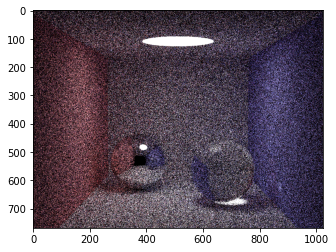

In [3]:
%time pixels = render(1024, 768, 8, jax.random.PRNGKey(0)).block_until_ready()
%time pixels = render(1024, 768, 8, jax.random.PRNGKey(0)).block_until_ready()
plt.imshow(pixels);

CPU times: user 103 ms, sys: 225 ms, total: 328 ms
Wall time: 560 ms


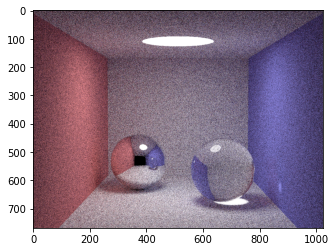

In [4]:
%time pixels = render(1024, 768, 64, jax.random.PRNGKey(0)).block_until_ready()
plt.imshow(pixels);

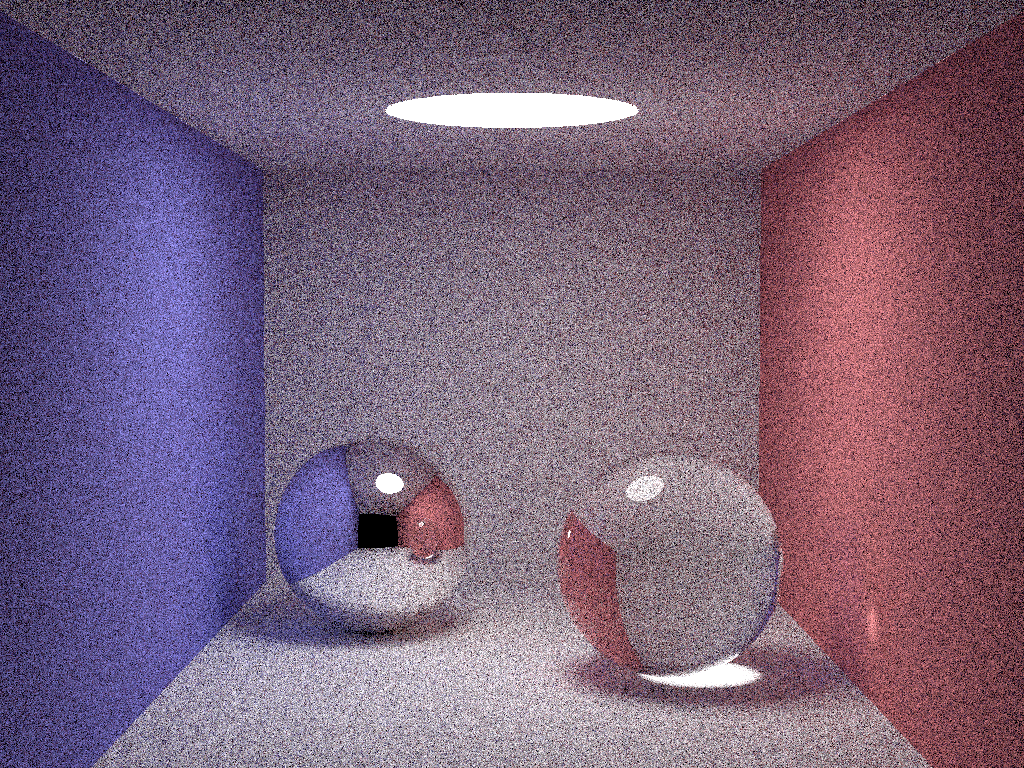

In [5]:
import cv2
import numpy as np
cv2.imwrite('image.png', np.array(pixels))
import IPython.display
IPython.display.Image('image.png')